# Risk Scoring & Underwriting
Risk Scoring and Underwriting are critical components in the financial and insurance industries, particularly in the evaluation and management of risk associated with lending, insurance policies, or other financial products.
## 1. Data Integration & Exploration

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

In [2]:
# Define a class
class ARDPreprocessor:
    """
    Automated Risk Data (ARD) Preprocessing Module
    Handles missing values, encodes categorical variables, and scales numerical features.
    """
    # Constructor method to initialize the class
    def __init__(self, num_strategy='median', cat_strategy='most_frequent', scaler=StandardScaler(), encoder=OneHotEncoder(handle_unknown='ignore')):
        self.num_imputer = SimpleImputer(strategy=num_strategy)
        self.cat_imputer = SimpleImputer(strategy=cat_strategy)
        self.scaler = scaler
        self.encoder = encoder
        self.preprocessor = None

        # Configure logging to display messages at the INFO level and above
        logging.basicConfig(level=logging.INFO)

    # Define a fit method to fit the preprocessing pipeline to the input data
    def fit(self, df, numeric_features, categorical_features):
        # Begin a try block to handle potential errors during fitting
        try:
            # Create a Pipeline for numeric features
            numeric_pipeline = Pipeline([
                ('imputer', self.num_imputer),
                ('scaler', self.scaler)
            ])
            # Create a Pipeline for categorical features
            categorical_pipeline = Pipeline([
                ('imputer', self.cat_imputer),
                ('encoder', self.encoder)
            ])
            # Combine the numeric and categorical pipelines into a single preprocessing object
            self.preprocessor = ColumnTransformer([
                ('num', numeric_pipeline, numeric_features),
                ('cat', categorical_pipeline, categorical_features)
            ])
            # Fit the ColumnTransformer to the input DataFrame df
            self.preprocessor.fit(df)
            logging.info("Preprocessor fitted successfully.")
        except Exception as e:
            logging.error(f"Error during fitting: {e}")
            raise

    # Apply the fitted preprocessing pipeline to transform the input data
    def transform(self, df):
        try:
            transformed_data = self.preprocessor.transform(df)
            feature_names = self.preprocessor.get_feature_names_out()
            return pd.DataFrame(transformed_data, columns=feature_names)
        except Exception as e:
            logging.error(f"Error during transformation: {e}")
            raise

    # Combine fitting and transformation into a single method
    def fit_transform(self, df, numeric_features, categorical_features):
        self.fit(df, numeric_features, categorical_features)
        return self.transform(df)

The `ARDPreprocessor` class is a modular and reusable preprocessing module.

- It handles missing values, scales numeric features, and encodes categorical features.

- It uses `Pipeline` and `ColumnTransformer` for a clean and consistent workflow.

- It includes error handling and logging for robustness.

- The `fit_transform` method provides a convenient way to fit and transform data in one step.

Here's a breakdown of the steps:

1. Fitting:

- The `SimpleImputer` learns the mean (or other specified statistic) of the numeric features.

- The `StandardScaler` computes the mean and standard deviation of the numeric features.

2. Transformation:

- The `SimpleImputer` replaces missing values with the learned mean.

- The `StandardScaler` standardizes the features using the computed mean and standard deviation.

In [3]:
# Load and combine multiple datasets
file_paths = ['application_record.csv', 'credit_record.csv']
dfs = [pd.read_csv(file) for file in file_paths]

# Concatenate DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

We've loaded and combined multiple datasets from the specified file paths.

In [4]:
# Creating Target Variable
def classify_risk(status):
    high_risk = {'2', '3', '4', '5'}
    low_risk = {'C', 'X', '0', '1'}
    return 1 if status in high_risk else 0

df['risk_flag'] = df['STATUS'].astype(str).apply(classify_risk)
logging.info("Target variable 'risk_flag' created based on STATUS")

In [5]:
# Feature Engineering
df['income_log'] = np.log1p(df['AMT_INCOME_TOTAL'].replace(0, np.nan))  # Replace zero values before log transformation
df['age_years'] = (-df['DAYS_BIRTH']) // 365
df['employment_length_years'] = (-df['DAYS_EMPLOYED']).clip(lower=0) // 365  # Clip negative values
df['dependents'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']
df['has_car_property'] = ((df['FLAG_OWN_CAR'] == 'Y') | (df['FLAG_OWN_REALTY'] == 'Y')).astype(int)

# Drop original columns after transformation
df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

### Feature Transformations & Rationale

| Feature Name              | Transformation Applied                                           | Rationale |
|---------------------------|----------------------------------------------------------------|-----------|
| `income_log`              | Log transformation on `AMT_INCOME_TOTAL`                      | Normalizes skewed income distribution for better model performance. |
| `age_years`              | Converted `DAYS_BIRTH` from days to years (`-DAYS_BIRTH / 365`) | Improves interpretability by representing age in a standard format. |
| `employment_length_years` | Converted `DAYS_EMPLOYED` to years (`-DAYS_EMPLOYED / 365`), clipped negatives | Handles anomalies where negative values exist and provides meaningful employment duration. |
| `dependents`             | Computed as `CNT_FAM_MEMBERS - CNT_CHILDREN`                   | Better represents financial dependents than just counting children. |
| `has_car_property`       | Created a binary flag from `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` (`1 if Y, else 0`) | Indicates asset ownership, which may impact financial stability. |

#### Visualizations for Feature Validation

To ensure that our engineered features differentiate well between low- and high-risk borrowers, we used visualizations:

##### 1. Log-Transformed Income Distribution
- **Purpose:** To check whether log transformation normalizes income distribution.
- **Visualization:** Histogram with KDE (Kernel Density Estimation).

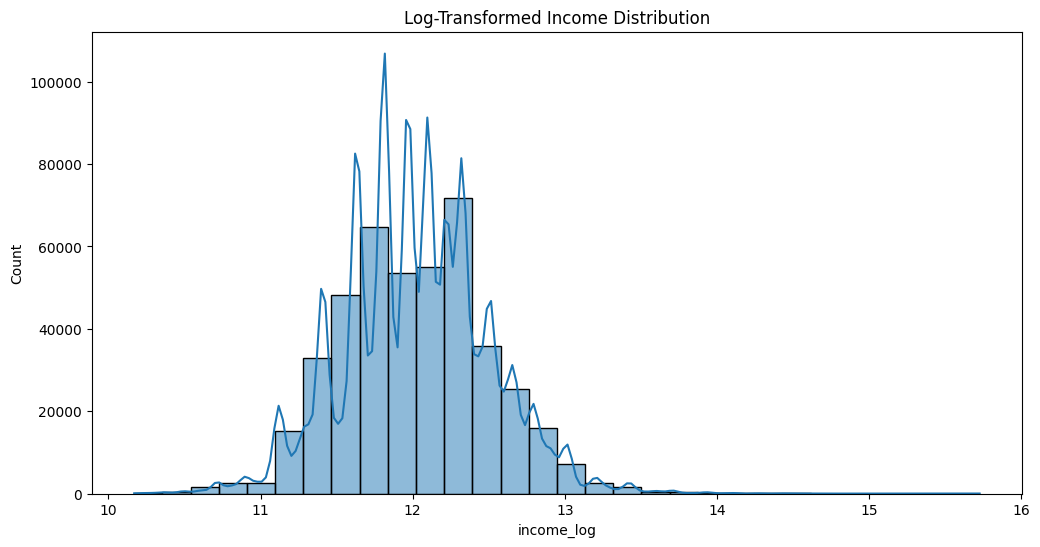

In [6]:
  plt.figure(figsize=(12, 6))
  sns.histplot(df['income_log'], bins=30, kde=True)
  plt.title("Log-Transformed Income Distribution")
  plt.show()

##### 2. Age Distribution
- **Purpose:** To verify if the age distribution is reasonable.
- **Visualization:** Histogram.

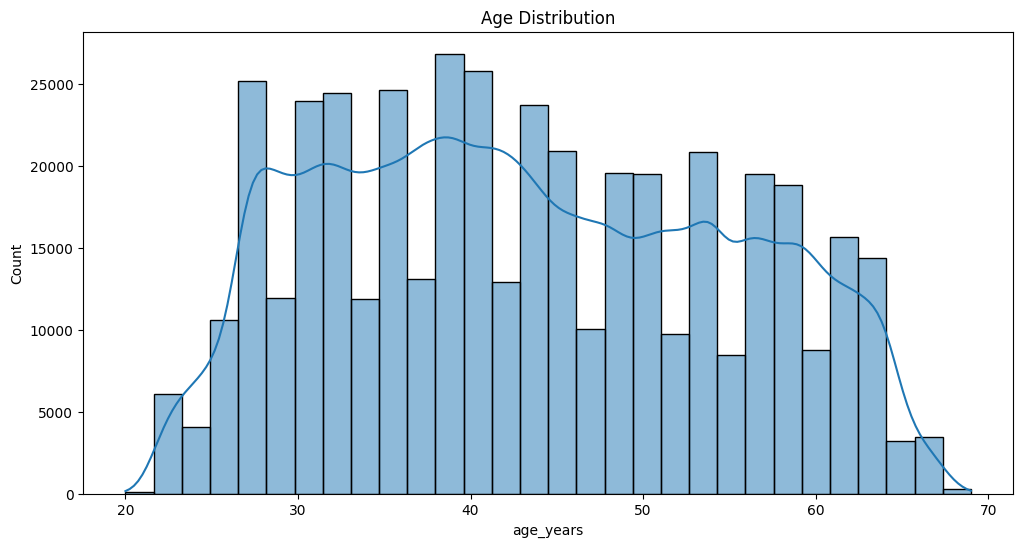

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df['age_years'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

##### 3. Income by Risk Category
- **Purpose:** To analyze whether income level impacts risk categorization.
- **Visualization:** Boxplot showing income_log distribution by risk_flag.

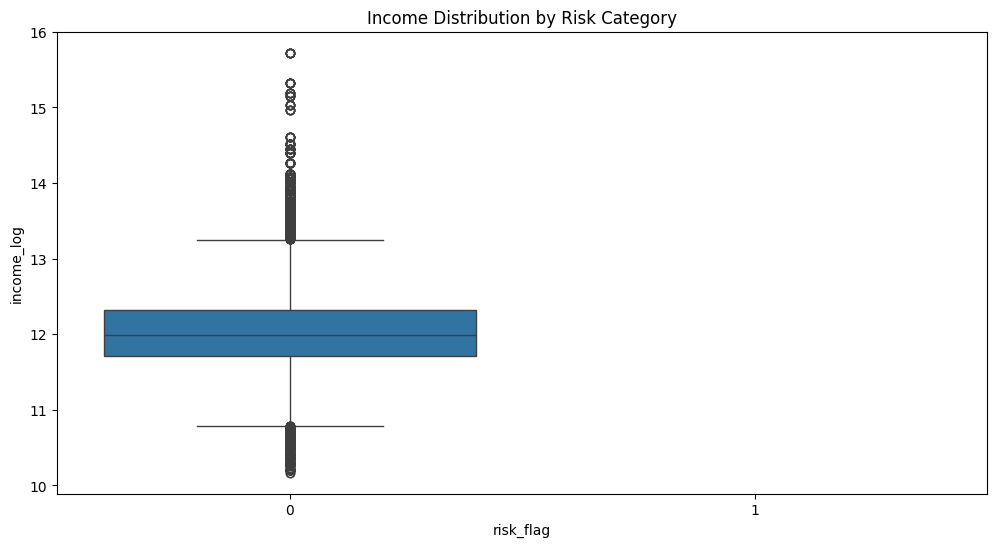

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['risk_flag'], y=df['income_log'])
plt.title("Income Distribution by Risk Category")
plt.show()

##### 4. Age by Risk Category
- **Purpose:** To check if age correlates with risk levels.
- **Visualization:** Boxplot showing age_years distribution by risk_flag.

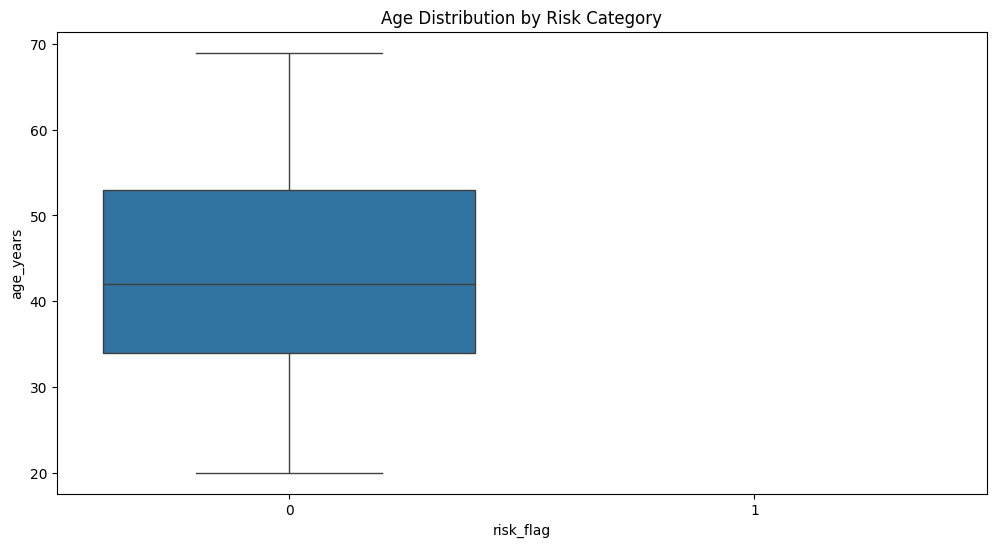

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['risk_flag'], y=df['age_years'])
plt.title("Age Distribution by Risk Category")
plt.show()

In [10]:
# Check the shape of the dataset (rows, columns)
print("Dataset shape (rows, columns):\n", df.shape)

# Get dataset information (column names, non-null counts, data types)
print("Dataset Info:\n")
df.info()

# Display first 5 rows
print("\nFirst 5 rows:\n", df.head())

# Summary statistics for numerical columns
print("Summary statistics:\n", df.describe())

# Check for missing values in numerical columns
print("Missing values in numerical columns:\n", df.isnull().sum())

Dataset shape (rows, columns):
 (1487132, 24)
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487132 entries, 0 to 1487131
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   ID                       1487132 non-null  int64  
 1   CODE_GENDER              438557 non-null   object 
 2   FLAG_OWN_CAR             438557 non-null   object 
 3   FLAG_OWN_REALTY          438557 non-null   object 
 4   CNT_CHILDREN             438557 non-null   float64
 5   AMT_INCOME_TOTAL         438557 non-null   float64
 6   NAME_INCOME_TYPE         438557 non-null   object 
 7   NAME_EDUCATION_TYPE      438557 non-null   object 
 8   NAME_FAMILY_STATUS       438557 non-null   object 
 9   NAME_HOUSING_TYPE        438557 non-null   object 
 10  FLAG_MOBIL               438557 non-null   float64
 11  FLAG_WORK_PHONE          438557 non-null   float64
 12  FLAG_PHONE               438557 non-n

In [16]:
# Define numerical and categorical features
numeric_features = ['AMT_INCOME_TOTAL', 'income_log', 'age_years', 'employment_length_years', 'dependents', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'has_car_property']
categorical_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

# Preprocess data using ARD module
preprocessor = ARDPreprocessor()
processed_data = preprocessor.fit_transform(df, numeric_features, categorical_features)
X = processed_data
y = df['risk_flag']

In [13]:
# Check the shape of the dataset (rows, columns)
print("Dataset shape (rows, columns):\n", processed_data.shape)

# Get dataset information (column names, non-null counts, data types)
print("Dataset Info:\n")
processed_data.info()

# Display first 5 rows
print("\nFirst 5 rows:\n", processed_data.head())

# Summary statistics for numerical columns
print("Summary statistics:\n", processed_data.describe())

# Check for missing values in columns
print("Missing values in columns:\n", processed_data.isnull().sum())

Dataset shape (rows, columns):
 (1487132, 57)
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487132 entries, 0 to 1487131
Data columns (total 57 columns):
 #   Column                                                  Non-Null Count    Dtype  
---  ------                                                  --------------    -----  
 0   num__AMT_INCOME_TOTAL                                   1487132 non-null  float64
 1   num__income_log                                         1487132 non-null  float64
 2   num__age_years                                          1487132 non-null  float64
 3   num__employment_length_years                            1487132 non-null  float64
 4   num__dependents                                         1487132 non-null  float64
 5   num__CNT_CHILDREN                                       1487132 non-null  float64
 6   num__CNT_FAM_MEMBERS                                    1487132 non-null  float64
 7   num__FLAG_MOBIL                       

## 3. Model Development & Evaluation

In [17]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training & Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    logging.info(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}")
    return accuracy, precision, recall, roc_auc

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

for name, model in models.items():
    logging.info(f"Training {name}")
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test)

C:\myProjects\Risk-Scoring-Underwriting\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myProjects\Risk-Scoring-Underwriting\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myProjects\Risk-Scoring-Underwriting\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
